## Complex PyTorch for Music Genre Classification

In [28]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

### Data Preparation

In [29]:
DATASET_PATH = "Data/train"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
BATCH_SIZE = 32
NUM_EPOCHS = 50

In [30]:
genre_list = os.listdir(DATASET_PATH)
if '.DS_Store' in genre_list: genre_list.remove('.DS_Store')
genre_mappings = dict(zip(genre_list, range(len(genre_list))))
print(genre_mappings)

{'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


### MFCCS

In [31]:
class MusicFeatureExtractorComplex2:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        mag_fft = np.square(np.abs(audio_fft))
        phase_fft = np.angle(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(mag_fft))
        phase_filtered = np.dot(filters, np.transpose(phase_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        phase_coefficents = np.dot(dct_filters, phase_filtered)
        return np.array([cepstral_coefficents]), np.array([phase_coefficents])

In [32]:
class GenreDatasetMFCC(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments
        self.dct_filter_num = dct_filter_num
        self.training = training

    def apply_augmentations(self, signal):
        # Apply augmentations to the audio signal
        if random.random() < 0.5:
            signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=random.uniform(-2, 2))
        if random.random() < 0.5:
            signal = librosa.effects.time_stretch(signal, rate=random.uniform(0.8, 1.2))
        return signal

    def adjust_shape(self, sequence, max_sequence_length = 126):
        current_length = sequence.shape[2]
        if current_length < max_sequence_length:
            padding = np.zeros((1, 13, max_sequence_length - current_length))
            padded_sequence = np.concatenate((sequence, padding), axis=2)
        else:
            padded_sequence = sequence[:, :, :max_sequence_length]
        return padded_sequence
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.float32), target

class GenreDatasetPhaseMFCC2(GenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = MusicFeatureExtractorComplex2(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc, cur_phase = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc, cur_phase = self.adjust_shape(cur_mfcc), self.adjust_shape(cur_phase)
        return torch.tensor(cur_mfcc, dtype=torch.float32), torch.tensor(cur_phase, dtype=torch.float32), target

In [33]:
train_dataset = GenreDatasetPhaseMFCC2("Data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GenreDatasetPhaseMFCC2("Data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

## 1. Simple Graph Net (Only magnitude)

In [34]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [35]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.283815	Accuracy: 9.38%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 2.285956	Accuracy: 15.53%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 2.140933	Accuracy: 17.06%
Epoch 0 - Time: 233.97s - Train Loss: 2.234477 - Train Accuracy: 17.37%
Test Loss: 2.186637 - Test Accuracy: 20.44%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 2.173024	Accuracy: 25.00%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 2.406570	Accuracy: 19.15%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 2.102077	Accuracy: 19.45%
Epoch 1 - Time: 226.15s - Train Loss: 2.182805 - Train Accuracy: 19.19%
Test Loss: 2.154018 - Test Accuracy: 20.75%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.015391	Accuracy: 34.38%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 2.243402	Accuracy: 19.06%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 2.275811	Accuracy: 19.56%
Epoch 2 - Time: 236.52s - Train Loss: 2.171332 - Train Accuracy: 19.48%
Test Loss: 2.191294 - Test Accuracy: 17.31%

Tr

## 2. Simple Graph Net (Magniude + phase wieghts)

In [36]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model([data, data2])
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model([data, data2])
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [37]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        x, phase_data = x[0], x[1]
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        phase_data = torch.mean(phase_data.view(-1, num_nodes, node_size), axis = 0)
        edge_weight = torch.tensor([torch.mean(np.abs(phase_data[edge_index[0][i].item()] - 
                                                      phase_data[edge_index[1][i].item()])).item() 
                                    for i in range(len(edge_index[0]))])
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index, edge_weight)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.479136	Accuracy: 6.25%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 2.111964	Accuracy: 16.49%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 2.072670	Accuracy: 18.86%
Epoch 0 - Time: 1216.79s - Train Loss: 2.162852 - Train Accuracy: 19.68%
Test Loss: 2.109093 - Test Accuracy: 22.25%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 1.894730	Accuracy: 25.00%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 2.064820	Accuracy: 22.62%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 2.095362	Accuracy: 23.46%
Epoch 1 - Time: 237.43s - Train Loss: 2.037587 - Train Accuracy: 24.28%
Test Loss: 2.066230 - Test Accuracy: 23.56%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.163065	Accuracy: 21.88%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 2.177595	Accuracy: 26.21%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.961488	Accuracy: 26.90%
Epoch 2 - Time: 3536.20s - Train Loss: 1.987517 - Train Accuracy: 26.82%
Test Loss: 2.096034 - Test Accuracy: 21.19%



## Plots

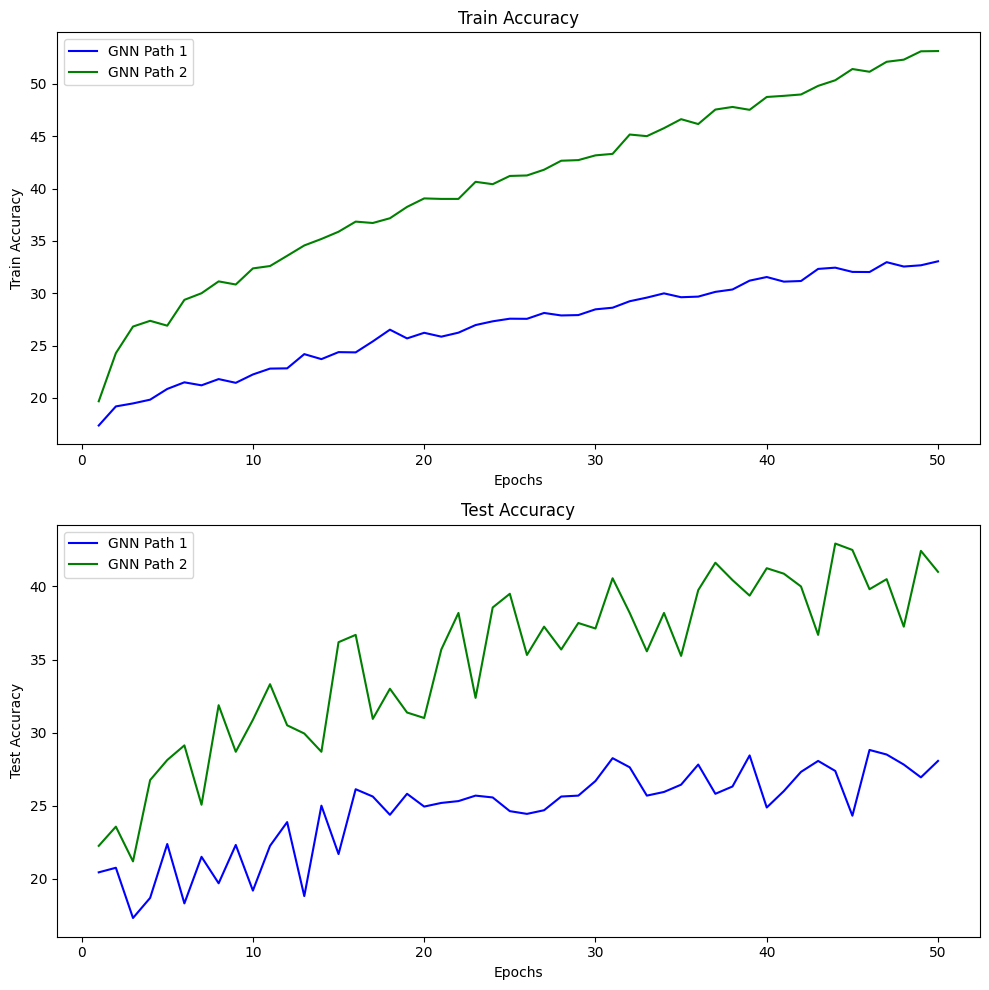

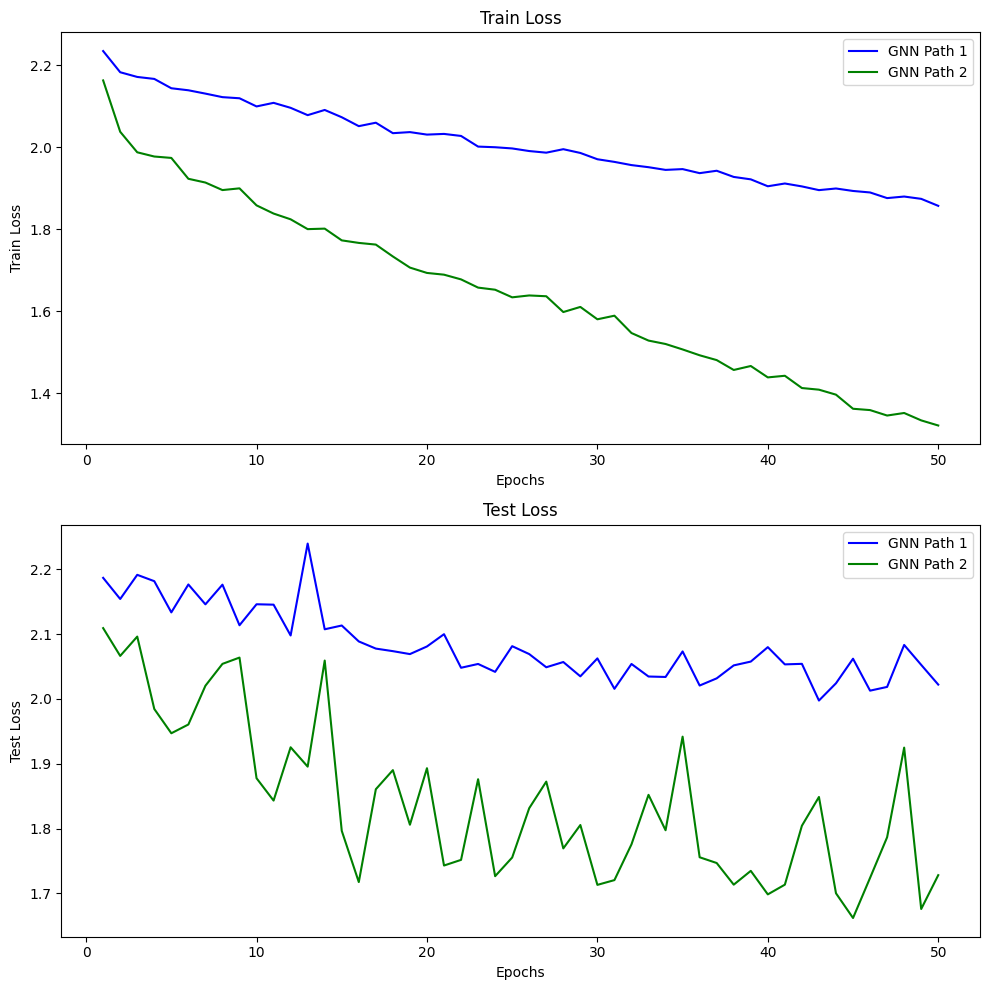

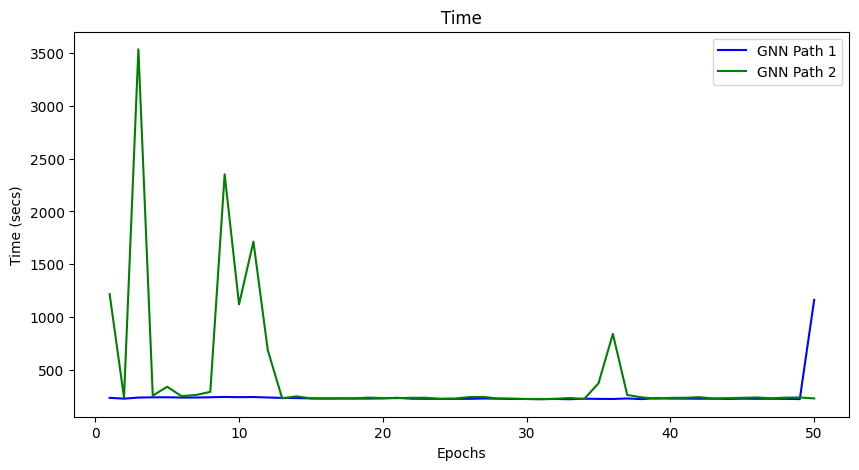

In [40]:
# Data for the four scenarios
data = {
    "GNN Path 1": metrics_dict_e1,
    "GNN Path 2": metrics_dict_e2,
}

# Data for plotting
epochs = range(1, 51)
colors = ['b', 'g', 'r', 'm', 'y', 'c', 'k', '#FF5733', '#7E4DFF']
scenarios = list(data.keys())

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])

axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Accuracy")
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])

axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Loss")
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

axes[1].set_title("Test Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for i, scenario in enumerate(scenarios):
    axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
axes.set_title("Time")
axes.set_xlabel("Epochs")
axes.set_ylabel("Time (secs)")
axes.legend()
